In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, BatchNormalization, Dropout, Bidirectional
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from keras import optimizers
import math

In [3]:
df = pd.read_csv('./Glucose_Train_Set.csv')

val_df = pd.read_csv('./Glucose_Validation_Set_Complete.csv')[['SID','Day','DailyTI_Index','Value']]
val_missing = pd.read_csv('./Glucose_Validation_Set.csv')[['SID','Day','DailyTI_Index','Value']]

In [4]:
missing_data = pd.merge(val_df, val_missing, on = ['SID','Day','DailyTI_Index'], how = 'left')
missing_data.columns = ['SID','Day','DailyTI_Index','Value_complete', 'Value_missing']

In [5]:
train_data = df.sort_values(by=['DailyTI_Index']).groupby(['SID', 'Day'])['Value'].apply(list).reset_index()
validation_missing = missing_data.sort_values(by=['DailyTI_Index']).groupby(['SID', 'Day'])['Value_missing'].apply(list).reset_index()
validation_complete = missing_data.sort_values(by=['DailyTI_Index']).groupby(['SID', 'Day'])['Value_complete'].apply(list).reset_index()


In [6]:
y_val = np.array(validation_missing['Value_missing'].to_list())

In [7]:
X_train = np.array(train_data['Value'].to_list())

In [8]:
# Normalize the data
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Reshaping X_train for the LSTM model, LSTM expects input to be in [samples, time steps, features]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

# Define a Seq2Seq LSTM model best was 50 and 50
model = Sequential([
    Bidirectional(LSTM(100, activation='sigmoid', input_shape=(288, 1), return_sequences=False)), # set to false for seq2seq
    RepeatVector(288),  # Determines the length of the output sequence
    Bidirectional(LSTM(100, activation='sigmoid', return_sequences=True)),
    TimeDistributed(Dense(1))
])

optimizer = optimizers.Adam(learning_rate = 0.001, clipvalue=0.5) # for seq2seq clipvalue=0.5
model.compile(optimizer=optimizer, loss='mse')

# Train the model
model.fit(X_train_reshaped, X_train_reshaped, epochs=20, batch_size=64, verbose=1)

Epoch 1/20


2024-04-03 08:48:48.382752: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1107/1107 [==============================] - 851s 768ms/step - loss: 0.6929
Epoch 2/20
1107/1107 [==============================] - 1359s 1s/step - loss: 0.4591
Epoch 3/20
1107/1107 [==============================] - 1666s 2s/step - loss: 0.3297
Epoch 4/20
1107/1107 [==============================] - 852s 770ms/step - loss: 0.2469
Epoch 5/20
1107/1107 [==============================] - 825s 745ms/step - loss: 0.2094
Epoch 6/20
1107/1107 [==============================] - 818s 739ms/step - loss: 0.1875
Epoch 7/20
1107/1107 [==============================] - 836s 755ms/step - loss: 0.1713
Epoch 8/20
1107/1107 [==============================] - 821s 742ms/step - loss: 0.1566
Epoch 9/20
1107/1107 [==============================] - 793s 717ms/step - loss: 0.1474
Epoch 10/20
1107/1107 [==============================] - 827s 747ms/step - loss: 0.1400
Epoch 11/20
1107/1107 [==============================] - 816s 737ms/step - loss: 0.1326
Epoch 12/20
1107/1107 [==============================] -

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 200)              81600     
 l)                                                              
                                                                 
 repeat_vector (RepeatVector  (None, 288, 200)         0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 288, 200)         240800    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 288, 1)           201       
 ibuted)                                                         
                                                                 
Total params: 322,601
Trainable params: 322,601
Non-trai

In [10]:
# Prepare the test sequence
test_sequences = y_val
# Handle NaNs for normalization (simple imputation, consider a better method for your use case)
test_sequences_imputed = np.array([np.where(np.isnan(seq), np.nanmean(seq), seq) for seq in test_sequences])

# Standardize the test sequences
test_sequences_scaled = scaler.transform(test_sequences_imputed)

# Reshape for the model
test_sequences_scaled_reshaped = test_sequences_scaled.reshape((test_sequences_scaled.shape[0], 288, 1))

# Predicting the sequences
predicted_sequences_scaled = model.predict(test_sequences_scaled_reshaped)

# Inverse transform to original scale
predicted_sequences = scaler.inverse_transform(predicted_sequences_scaled.reshape(test_sequences_scaled.shape[0], 288))


317/317 [==============================] - 57s 180ms/step


In [11]:
predictions = []

# Iterate through each row in the array and append it as a list to data_for_df
for row in predicted_sequences:
    predictions.append(row)  # Each row becomes a list that is then wrapped in another list to represent a single cell in the DataFrame


In [21]:
validation_missing['Value_prediction_seq'] = predictions

In [22]:
preds_vs_true = pd.merge(validation_missing, validation_complete)

In [23]:
def find_nan_indices(lst):
    """
    Returns a list of indices where the item in the list is NaN.
    
    :param lst: List to check for NaN values.
    :return: List of indices with NaN values.
    """
    return [i for i, x in enumerate(lst) if isinstance(x, float) and np.isnan(x)]

# Now, apply the function to the 'Value_missing' column
preds_vs_true['Missing_Indexes'] = preds_vs_true['Value_missing'].apply(find_nan_indices)

In [24]:
RMSEs =[]
missing_count = []
predicted_values = []
true_values = []

for j in range(len(preds_vs_true)):
    check_list = []
    count = 0
    pred_vals = []
    true_val = []
    for i in find_nan_indices(preds_vs_true['Value_missing'][j]):
        check_list.append((preds_vs_true['Value_complete'][j][i] - preds_vs_true['Value_prediction_seq'][j][i])**2)
        count += 1
        pred_vals.append(preds_vs_true['Value_prediction_seq'][j][i])
        true_val.append(preds_vs_true['Value_complete'][j][i])
    
    RMSEs.append(np.mean(check_list)**(1/2))
    missing_count.append(count)
    predicted_values.append(pred_vals)
    true_values.append(true_val)

In [25]:
preds_vs_true['Avg RMSE'] = RMSEs
preds_vs_true['missing_count'] = missing_count
preds_vs_true['Predicted_Values'] = predicted_values
preds_vs_true['True_Values'] = true_values

In [26]:
preds_vs_true['offset_start'] = preds_vs_true['Missing_Indexes'].apply(np.array).apply(min)-1
preds_vs_true['offset_value'] = preds_vs_true.apply(lambda row: row['Value_missing'][row['offset_start']], axis=1) - \
                                    preds_vs_true.apply(lambda row: row['Value_prediction_seq'][row['offset_start']], axis=1)



In [27]:
# Add the single float to each element of the lists
preds_vs_true['Offset_Predicted_Values'] = preds_vs_true.apply(lambda row: [x + row['offset_value'] for x in row['Predicted_Values']], axis=1)

In [28]:
# Add the single float to each element of the lists
preds_vs_true['Offset_Predicted_Values'] = preds_vs_true.apply(lambda row: [x + row['offset_value'] for x in row['Predicted_Values']], axis=1)

In [29]:
preds_vs_true.groupby('missing_count')['Avg RMSE'].mean()

missing_count
4     17.986108
5     20.231684
6     20.514382
7     21.632985
8     22.884517
9     23.977975
10    24.519893
11    27.158043
12    28.103898
24    38.947642
48    50.214561
96    58.266760
Name: Avg RMSE, dtype: float64

In [30]:
# Display the DataFrame
preds_vs_true['Offset_Sq_Error'] = preds_vs_true.apply(lambda row: [(a - b)**2 for a, b in zip(row['True_Values'], row['Offset_Predicted_Values'])], axis=1)

In [31]:
preds_vs_true['Offset_RMSE']= preds_vs_true['Offset_Sq_Error'].apply(np.array).apply(np.mean).apply(math.sqrt)

In [43]:
preds_vs_true.to_csv('Seq2Seq_Bidirectional_100nodes.csv', index = False)

In [44]:
pd.read_csv('Seq2Seq_Bidirectional_100nodes.csv')

,SID,Day,Value_missing,Value_prediction,Value_prediction_seq,Value_complete,Missing_Indexes,Avg RMSE,missing_count,Predicted_Values,True_Values,offset_start,offset_value,Offset_Predicted_Values,Offset_Sq_Error,Offset_RMSE
0,CITY-1,2,"[306.0, 301.0, 301.0, 301.0, 300.0, 306.0, 312...",[287.3701 297.58356 297.6433 297.43558 2...,[287.3701 297.58356 297.6433 297.43558 2...,"[306.0, 301.0, 301.0, 301.0, 300.0, 306.0, 312...","[30, 31, 32, 33]",10.406688,4,"[261.76562, 258.7067, 255.58145, 252.41585]","[268.0, 271.0, 255.0, 268.0]",29,1.304199,"[263.06982421875, 260.0108947753906, 256.88565...","[24.306633234024048, 120.76043363753706, 3.555...",9.388022
1,CITY-1,11,"[248.0, 251.0, 251.0, 254.0, 257.0, 262.0, 268...",[249.40462 255.71817 254.84705 254.03822 2...,[249.40462 255.71817 254.84705 254.03822 2...,"[248.0, 251.0, 251.0, 254.0, 257.0, 262.0, 268...","[77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 8...",181.934481,96,"[289.3993, 283.76468, 277.86426, 271.7225, 265...","[370.0, 371.0, 374.0, 376.0, 379.0, 380.0, 353...",76,72.231171,"[361.6304626464844, 355.995849609375, 350.0954...","[70.04915551189333, 225.12452894449234, 571.42...",113.697815
2,CITY-1,207,"[206.0, 204.0, 202.0, 202.0, 204.0, 208.0, 211...",[198.94165 206.15321 205.42213 205.0272 2...,[198.94165 206.15321 205.42213 205.0272 2...,"[206.0, 204.0, 202.0, 202.0, 204.0, 208.0, 211...","[266, 267, 268, 269, 270, 271, 272]",18.008322,7,"[166.59639, 164.67213, 162.91809, 161.32664, 1...","[185.0, 186.0, 184.0, 178.0, 175.0, 174.0, 175.0]",265,13.348740,"[179.94512939453125, 178.0208740234375, 176.26...","[25.551716838032007, 63.66645134985447, 59.801...",5.089628
3,CITY-1,282,"[266.0, 270.0, 265.0, 261.0, 258.0, 257.0, 253...",[257.39426 265.40396 264.09146 261.9725 259.8...,[257.39426 265.40396 264.09146 261.9725 259.8...,"[266.0, 270.0, 265.0, 261.0, 258.0, 257.0, 253...","[108, 109, 110, 111, 112, 113, 114, 115, 116, ...",129.325938,48,"[156.82378, 161.36487, 166.26886, 171.55228, 1...","[88.0, 86.0, 83.0, 81.0, 80.0, 82.0, 85.0, 87....",107,-61.635620,"[95.18815612792969, 99.729248046875, 104.63323...","[51.66958851949312, 188.492251932621, 467.9970...",69.514701
4,CITY-1,283,"[234.0, 223.0, 214.0, 206.0, 195.0, 180.0, 167...",[215.86612 215.33398 208.49551 202.88972 1...,[215.86612 215.33398 208.49551 202.88972 1...,"[234.0, 223.0, 214.0, 206.0, 195.0, 180.0, 167...","[108, 109, 110, 111, 112, 113, 114, 115, 116, ...",26.526092,24,"[172.56993, 172.6088, 172.96222, 173.67265, 17...","[204.0, 203.0, 206.0, 206.0, 204.0, 205.0, 208...",107,29.186157,"[201.75608825683594, 201.79495239257812, 202.1...","[5.035139911109582, 1.4521397361531854, 14.835...",23.818273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10113,WISDM-98,174,"[91.0, 92.0, 92.0, 93.0, 94.0, 95.0, 94.0, 94....",[100.51206 91.912415 85.14664 82.8822 ...,[100.51206 91.912415 85.14664 82.8822 ...,"[91.0, 92.0, 92.0, 93.0, 94.0, 95.0, 94.0, 94....","[26, 27, 28, 29, 30, 31, 32, 33, 34]",15.682970,9,"[100.12927, 101.63558, 103.122635, 104.61268, ...","[118.0, 120.0, 122.0, 123.0, 123.0, 123.0, 122...",25,15.365105,"[115.49437713623047, 117.00068664550781, 118.4...","[6.278145935444627, 8.995880598435178, 12.3359...",3.693957
10114,WISDM-98,183,"[158.0, 163.0, 153.0, 122.0, 125.0, 126.0, 148...",[147.26544 142.0669 134.92786 131.41635 1...,[147.26544 142.0669 134.92786 131.41635 1...,"[158.0, 163.0, 153.0, 122.0, 125.0, 126.0, 148...","[244, 245, 246, 247, 248, 249]",23.556261,6,"[92.25856, 92.251274, 92.356064, 92.647514, 93...","[68.0, 58.0, 64.0, 69.0, 80.0, 88.0]",243,-21.432808,"[70.82575225830078, 70.81846618652344, 70.9232...","[7.984875825291965, 164.31307537504472, 47.931...",9.497271
10115,WISDM-98,185,"[183.0, 193.0, 194.0, 192.0, 195.0, 195.0, 199...",[189.44418 193.97711 192.6291 192.99515 1...,[189.44418 193.97711 192.6291 192.99515 1...,"[183.0, 193.0, 194.0, 192.0, 195.0, 195.0, 199...","[46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 5...",26.346600,48,"[175.87027, 174.

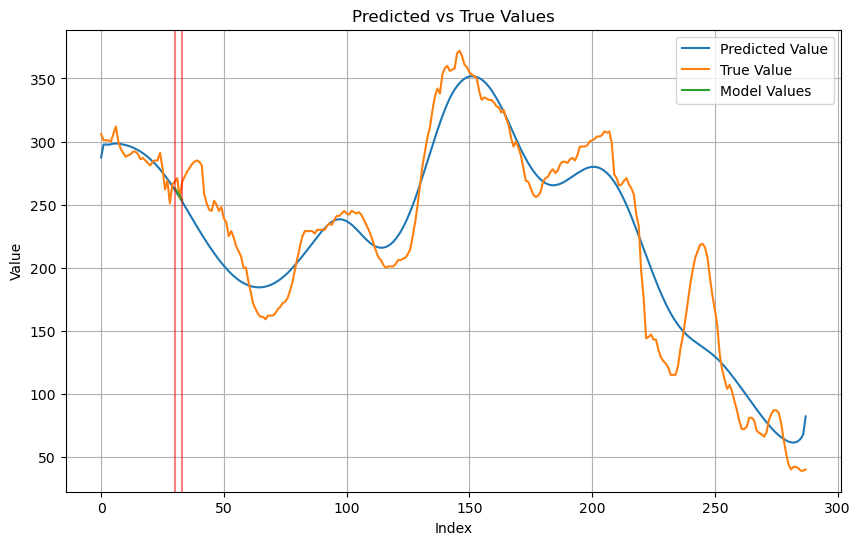

In [41]:
val_point = 0

compare_dataframe = pd.DataFrame({'True Value':preds_vs_true['Value_complete'][val_point].copy(), 'Predicted Value':preds_vs_true['Value_prediction'][val_point].copy()})

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(compare_dataframe.index, compare_dataframe['Predicted Value'], label='Predicted Value')
plt.plot(compare_dataframe.index, compare_dataframe['True Value'], label='True Value')
plt.plot(preds_vs_true['Missing_Indexes'][val_point], preds_vs_true['Offset_Predicted_Values'][val_point], label = 'Model Values')

plt.axvline(x=np.array(preds_vs_true['Missing_Indexes'][val_point]).min(), color='red', alpha=0.5)
plt.axvline(x=np.array(preds_vs_true['Missing_Indexes'][val_point]).max(), color='red', alpha=0.5)

plt.title('Predicted vs True Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()